# Chapitre 1

Bienvenue dans ce chapitre interactif utilisant ThebeLab !

## Exemple de code interactif

```{thebe-button}

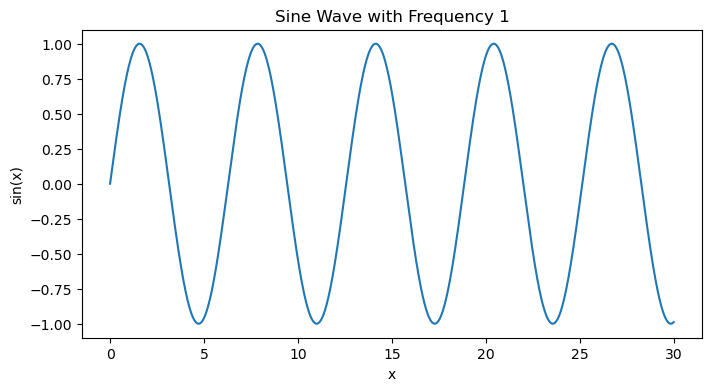

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sine(frequency=1):
    x = np.linspace(0, 30, 1000)
    y = np.sin(frequency * x)
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    plt.title(f'Sine Wave with Frequency {frequency}')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.show()

plot_sine()

```{code-cell} fenicsx-env

In [2]:
# Importation des librairies
import dolfinx  # Module principal de FEniCSx pour le calcul par éléments finis
from dolfinx import mesh, fem, plot, io, default_scalar_type  # Sous-modules FEniCSx essentiels
from dolfinx.fem.petsc import LinearProblem  # Résolution de systèmes linéaires
from mpi4py import MPI  # Interface pour le calcul parallèle
import ufl  # Unified Form Language pour les formulations variationnelles
import numpy as np  # Calcul numérique efficace
import matplotlib.pyplot as plt
import math  # Module de fonctions mathématiques standard de Python
import pyvista as pv  # Visualisation 3D scientifique
import gmsh  # Générateur de maillage 3D
import meshio  # Lecture/écriture de différents formats de maillage
from dolfinx.io import XDMFFile  # Gestion des fichiers XDMF pour données volumineuses
import dolfinx.fem as fem  # Module FEniCSx pour la méthode des éléments finis
import dolfinx.mesh as mesh  # Module FEniCSx pour la gestion avancée des maillages
from petsc4py import PETSc  # Suite de solveurs numériques pour problèmes à grande échelle
import panel as pn
from myst_nb import glue
# Utiliser Panel pour créer un rendu interactif
pn.extension('vtk')

In [3]:
# Initialisation de GMSH
gmsh.initialize()
gmsh.model.add("ellipse")

# Définition des paramètres géométriques et de maillage
a = 0.2  # Demi-grand axe de l'ellipse en mètres
b = 0.2  # Demi-petit axe de l'ellipse en mètres
h = 1.0  # Hauteur du cylindre elliptique en mètres
# Calcul du rayon équivalent du cylindre elliptique
R = 1/2 * np.sqrt(a**2 + b**2)

# Création de la géométrie : ellipse de base
ellipse = gmsh.model.occ.addEllipse(0, 0, 0, a, b)

# Création d'une boucle fermée à partir de l'ellipse
curve_loop = gmsh.model.occ.addCurveLoop([ellipse])

# Création d'une surface plane à partir de la boucle
surface = gmsh.model.occ.addPlaneSurface([curve_loop])

# Extrusion de la surface pour créer un cylindre elliptique
gmsh.model.occ.extrude([(2, surface)], 0, 0, h)

# Synchronisation du modèle géométrique
gmsh.model.occ.synchronize()

# Configuration des paramètres de maillage
lc = 0.02  # Taille caractéristique des éléments du maillage en mètres
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Génération du maillage volumique (3D)
gmsh.model.mesh.generate(3)

# Sauvegarde du maillage au format .msh
gmsh.write("ellipse.msh")

# Finalisation de GMSH
gmsh.finalize()

# Lecture du fichier .msh avec meshio
msh = meshio.read("ellipse.msh")

# Conversion et sauvegarde du maillage au format XDMF (compatible avec FEniCSx)
meshio.write("ellipse.xdmf", meshio.Mesh(points=msh.points, cells={"tetra": msh.cells_dict.get("tetra", [])}))

# Lecture du maillage XDMF avec FEniCSx
with XDMFFile(MPI.COMM_WORLD, "ellipse.xdmf", "r") as xdmf_file:
    domain = xdmf_file.read_mesh(name="Grid")
    domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# Affichage des informations sur le maillage
print("Maillage créé et importé avec succès.")
print(f"Nombre de sommets : {domain.topology.index_map(domain.topology.dim).size_global}")
print(f"Nombre d'éléments : {domain.topology.index_map(domain.topology.dim-1).size_global}")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 40%] Meshing curve 2 (Line)
Info    : [ 70%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.00017875s, CPU 0.000287s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Unknown, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.14742s, CPU 0.143183s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 4451 nodes...
Info    : Done tetrahedrizing 4459 nodes (Wall 0.0354808s, CPU 0.034895s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.165925s, CPU 0.163469s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 10.6389 (nodes removed 0 0)
Info    : It. 50

In [4]:
# Préparation du maillage pour la visualisation avec PyVista
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(domain)

# Création d'une grille non structurée PyVista à partir des données du maillage FEniCSx
u_grid = pv.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

# Initialisation de l'environnement de visualisation PyVista
p = pv.Plotter()

# Ajout du maillage à la scène de visualisation
p.add_mesh(u_grid, 
           show_edges=True,  # Affiche les arêtes du maillage
           scalar_bar_args={
               "title": "u",  # Titre de la barre de couleur
               "title_font_size": 24,
               "label_font_size": 22,
               "shadow": True,
               "italic": True,
               "font_family": "arial",
               "vertical": False  # Orientation horizontale de la barre de couleur
           })

# Ajout d'un titre à la visualisation
p.add_text("Cylindre Mesh", font_size=24, color="black", position="upper_edge")

# Ajout des limites de la boîte englobante
p.show_bounds(color="black")

# Ajout des axes de coordonnées
p.add_axes(color="black")

# Définition de la couleur de fond
p.set_background("grey")

# Affichage de la visualisation
p.show()

# Changement de la vue pour une perspective Y-Z
p.view_yz()

Widget(value='<iframe src="http://localhost:51367/index.html?ui=P_0x11b4cfbf0_0&reconnect=auto" class="pyvista…

In [5]:
interactive_panel = pn.pane.VTK(p.ren_win, width=755, height=400)
from myst_nb import glue
glue("img", interactive_panel)

VTKRenderWindowSynchronized(vtkCocoaRenderWindow, height=400, sizing_mode='fixed', width=755)

In [6]:
interactive_panel

VTKRenderWindowSynchronized(vtkCocoaRenderWindow, height=400, sizing_mode='fixed', width=755)